**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [212]:
data = pd.read_csv('Kobe.csv')

In [213]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [214]:
# Смотрим на уникальные значения в признаках
for col in data.columns:
    #if len(data[col].unique()):
    print('Column: {0:}, type: {1:}:\n {2:} \n'.format(col, data[col].dtype, data[col].unique()))


Column: action_type, type: object:
 ['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Driving Layup Shot' 'Reverse Layup Shot' 'Reverse Dunk Shot'
 'Slam Dunk Shot' 'Turnaround Jump Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Running Tip Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Reverse Slam Dunk Shot' 'Turnaround Bank shot'
 'Running Finger Roll Layup Shot' 'Floating Jump shot'
 'Putback Slam Dunk Shot' 'Running Bank shot' 'Driv

In [215]:
# удаляем:
#team_id и team_name, т.к. они имеют единственные значения
# и game_event_id, game_id - это просто id игры, и shot_id
# shot_zone_range, shot_type, т.к. это катерогиальный признак для shot_distance
# action_type, т.к связан с combined_shot_type
# game_date, т.к .связан с season
# lat, lon, т.к. связаны с loc_x, loc_y
to_remove = ['team_id', 'team_name', 'game_event_id', 'game_id', 'shot_id', 
             'shot_zone_range', 'shot_type', 'action_type', 'game_date', 'lat', 'lon']
data.drop(to_remove, inplace=True, axis=1)
None

In [216]:
# преобразуем matchup в колонку с домашней игрой
data['home_play'] = data['matchup'].str.contains('vs').astype("int")
data.drop(['matchup'], inplace=True, axis=1)

In [217]:
# объединим period, minutes_remaining и seconds_remaining и переведем в секунды с начала игры
data['time_remaning'] = data['period'] * 12 * 60 - (data['minutes_remaining'] * 60 + data['seconds_remaining'])
data.drop(['period', 'minutes_remaining', 'seconds_remaining'], inplace=True, axis=1)

In [218]:
# объединим shot_zone_area, shot_zone_basic
data['shot_zone'] = data['shot_zone_area'] + data['shot_zone_basic']
data.drop(['shot_zone_area', 'shot_zone_basic'], inplace=True, axis=1)

In [219]:
# переводим категориальные переменные в цисловые
cols_to_dummies = ['combined_shot_type' , 'season', 'opponent', 'shot_zone']

data_d = pd.get_dummies(data, cols_to_dummies)

In [220]:
# выделим данные целевой переменной с пустыми в отдельную выборку
test = data_d[data_d['shot_made_flag'].isnull()]

In [221]:
# Выделим данные, с которыми будем работать
data_tr = data_d[data_d['shot_made_flag'].notnull()]

In [222]:
# разделим на данные с признаками и целевой переменной
X = data_tr.drop(['shot_made_flag'], axis=1)
y = data_tr['shot_made_flag']
X_test = test.drop(['shot_made_flag'], axis=1)
y_test = test['shot_made_flag']

In [223]:
# разделим на данные на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [224]:
# Нормализуем
sc = StandardScaler()
X_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [225]:
# Обучим линейную модель, Lasso, Ridge (с встроеной регуляризацией)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

LinR = LinearRegression()
RC = RidgeClassifier(random_state=0)
L = Lasso(random_state=0)


In [226]:
models = [LinR, RC, L]

for model in models:
    model.fit(X_scaled,y_train)
    y_pred=model.predict(X_scaled)
    yt_pred=model.predict(X_test_scaled)
    print(model)
    print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, model.predict(X_scaled))))
    print('Test roc_auc_score: {}\n'.format(roc_auc_score(y_test, model.predict(X_test_scaled))))
    print(classification_report(y_test, np.where(yt_pred >= 0.5, 1, 0), target_names=['не забил', 'забил'], zero_division=0))
    print('________________________________\n')

LinearRegression()
Train roc_auc_score: 0.6344270345693699
Test roc_auc_score: 0.6161695645662001

              precision    recall  f1-score   support

    не забил       0.61      0.84      0.70      4270
       забил       0.62      0.33      0.43      3440

    accuracy                           0.61      7710
   macro avg       0.61      0.58      0.57      7710
weighted avg       0.61      0.61      0.58      7710

________________________________

RidgeClassifier(random_state=0)
Train roc_auc_score: 0.5905792728880651
Test roc_auc_score: 0.582337563313545

              precision    recall  f1-score   support

    не забил       0.61      0.84      0.70      4270
       забил       0.62      0.33      0.43      3440

    accuracy                           0.61      7710
   macro avg       0.61      0.58      0.57      7710
weighted avg       0.61      0.61      0.58      7710

________________________________

Lasso(random_state=0)
Train roc_auc_score: 0.5
Test roc_auc_score: 0

Видим, что модель Lasso зануляет признаки, за счет чего, предсказанные значения становятся неверными

In [227]:
# Построиv PCA на подготовленных признаках 
# и уменьшим размерность до 1
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

xxx = pca.fit_transform(X_scaled)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)


[4.33118702]
[0.05346847]


Text(0, 0.5, 'Признак')

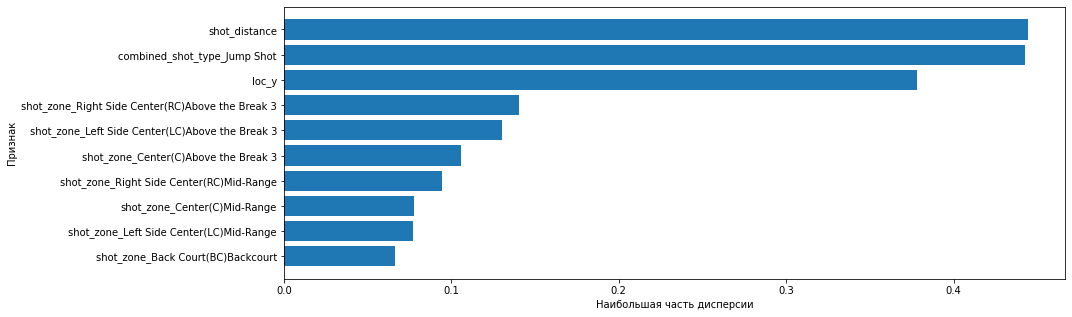

In [228]:
# Посмотрим TOP10 компонент, составляющих наибольшую часть дисперсии целевой переменной
l = list(zip(X_train.columns, *pca.components_))
l.sort(key=lambda i: i[1])
f, v = zip(*l[-10:])
plt.figure(figsize=(14,5)) 
n_features = 10
plt.barh(range(n_features), v, align='center')
plt.yticks(np.arange(n_features), f)
plt.xlabel("Наибольшая часть дисперсии")
plt.ylabel("Признак")